Import data

In [29]:
import numpy as np
import pandas as pd
# Import data from csv
# data = pd.read_csv('App/Daten/data_new/detail.csv')
d1 = pd.read_csv('App/Daten/data_new/detail1.csv')
d2 = pd.read_csv('App/Daten/data_new/detail2.csv')
data = pd.concat([d1, d2], axis=0)

In [30]:
data.columns

Index(['BETRIEBSTAG', 'AN_diff', 'weekday', 'ab_hour', 'ab_minute', 'feiertag',
       'Temperatur', 'Niederschlag', 'Luftfeuchtigkeit', 'Wind', 'week',
       'haltestelle_ab_Basel SBB', 'haltestelle_ab_Bern',
       'haltestelle_ab_Lugano', 'haltestelle_ab_Luzern',
       'haltestelle_ab_Olten', 'haltestelle_ab_St. Gallen',
       'haltestelle_ab_Zürich HB', 'haltestelle_an_Basel SBB',
       'haltestelle_an_Bern', 'haltestelle_an_Lugano', 'haltestelle_an_Luzern',
       'haltestelle_an_Olten', 'haltestelle_an_St. Gallen',
       'haltestelle_an_Zürich HB', 'LINIEN_TEXT_EC', 'LINIEN_TEXT_IC',
       'LINIEN_TEXT_IC1', 'LINIEN_TEXT_IC2', 'LINIEN_TEXT_IC21',
       'LINIEN_TEXT_IC3', 'LINIEN_TEXT_IC5', 'LINIEN_TEXT_IC6',
       'LINIEN_TEXT_IC61', 'LINIEN_TEXT_IC8', 'LINIEN_TEXT_IC81',
       'LINIEN_TEXT_ICE', 'LINIEN_TEXT_IR', 'LINIEN_TEXT_IR13',
       'LINIEN_TEXT_IR15', 'LINIEN_TEXT_IR16', 'LINIEN_TEXT_IR17',
       'LINIEN_TEXT_IR26', 'LINIEN_TEXT_IR27', 'LINIEN_TEXT_IR35',
     

In [31]:
betriebstage = data['BETRIEBSTAG']
data.drop('BETRIEBSTAG', axis=1, inplace=True)

In [32]:
# Assuming your dataframe is called 'df' and the dummy columns start with 'departure_'
data['haltestelle_ab'] = data.filter(like='haltestelle_ab_').idxmax(axis=1)
data['haltestelle_ab'] = data['haltestelle_ab'].str.replace('haltestelle_ab_', '')
data.drop(data.filter(like='haltestelle_ab_').columns, axis=1, inplace=True)


In [33]:
# # find columns with NaN
# na_cols = data.columns[data.isna().any()].tolist()
# data = data.drop(na_cols, axis=1)
data = data.dropna()

In [34]:
haltestellen = data['haltestelle_ab'].unique()
haltestellen

array(['Bern', 'Olten', 'St. Gallen', 'Basel SBB', 'Lugano', 'Luzern',
       'Zürich HB'], dtype=object)

In [35]:
from sklearn.ensemble import VotingRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
import pickle
from joblib import dump

In [ ]:
data.info()

In [38]:
data.columns

Index(['AN_diff', 'weekday', 'ab_hour', 'ab_minute', 'feiertag', 'Temperatur',
       'Niederschlag', 'Luftfeuchtigkeit', 'Wind', 'week',
       'haltestelle_an_Basel SBB', 'haltestelle_an_Bern',
       'haltestelle_an_Lugano', 'haltestelle_an_Luzern',
       'haltestelle_an_Olten', 'haltestelle_an_St. Gallen',
       'haltestelle_an_Zürich HB', 'LINIEN_TEXT_EC', 'LINIEN_TEXT_IC',
       'LINIEN_TEXT_IC1', 'LINIEN_TEXT_IC2', 'LINIEN_TEXT_IC21',
       'LINIEN_TEXT_IC3', 'LINIEN_TEXT_IC5', 'LINIEN_TEXT_IC6',
       'LINIEN_TEXT_IC61', 'LINIEN_TEXT_IC8', 'LINIEN_TEXT_IC81',
       'LINIEN_TEXT_ICE', 'LINIEN_TEXT_IR', 'LINIEN_TEXT_IR13',
       'LINIEN_TEXT_IR15', 'LINIEN_TEXT_IR16', 'LINIEN_TEXT_IR17',
       'LINIEN_TEXT_IR26', 'LINIEN_TEXT_IR27', 'LINIEN_TEXT_IR35',
       'LINIEN_TEXT_IR36', 'LINIEN_TEXT_IR37', 'LINIEN_TEXT_IR70',
       'LINIEN_TEXT_IR75', 'Einschr_type_Aufgehoben:',
       'Einschr_type_Einschraenkung', 'Einschr_type_Endmeldung:',
       'Einschr_type_Keine', 'Einsc

models per station

In [36]:
# Initialize dictionary for storing models for each departure station
models_per_station = {}

# Initialize dictionary for storing results per station
results_per_station = {}

for station in haltestellen:
    # Filter the data for the current departure station
    data_station = data[data['haltestelle_ab'] == station]

    # Drop the departure station column
    data_station = data_station.drop('haltestelle_ab', axis=1)

    # Define X and y
    X = data_station.drop('AN_diff', axis=1)
    y = data_station['AN_diff']

    # Split data into train and test set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=4153)

    models = [
        # ('LinearRegression', LinearRegression()),
        ('RandomForestRegressor', RandomForestRegressor(random_state=4153)),
        ('XGBRegressor', XGBRegressor(random_state=4153))
    ]

    # Initialize list for base estimators of VotingRegressor
    estimators = {}

    # Initialize empty dataframe for results
    all_results_voting = pd.DataFrame()

    for name, model in models:
        model.fit(X_train, y_train)

        # Add the model to the estimators list
        estimators[name] = model

        # Predict y
        y_pred = model.predict(X_test)

        # Calculate metrics
        r2 = r2_score(y_test, y_pred)
        rmse = mean_squared_error(y_test, y_pred, squared=False)
        mape = mean_absolute_percentage_error(y_test, y_pred)

        # Save results in a dictionary
        result = {'R2': r2, 'RMSE': rmse, 'MAPE': mape, 'modelname': name}

        # Add to results dataframe
        all_results_voting = pd.concat([all_results_voting, pd.DataFrame([result])], ignore_index=True)

    # find best model 
    best_model_name = 'XGBRegressor' # all_results_voting.sort_values(by=['RMSE']).iloc[0]['modelname']
    best_model = estimators[best_model_name]
    # save best model
    with open(f'App/Modell/Orte/{station}_{best_model_name}.pkl', 'wb') as f:
        pickle.dump(best_model, f)

    # Voting Regressor
    voting_regressor = VotingRegressor(list(estimators.items()))
    voting_regressor.fit(X_train, y_train)

    # Add model to estimators list
    estimators['VotingRegressor'] = voting_regressor

    # Predict y
    y_pred = voting_regressor.predict(X_test)

    # Calculate metrics
    r2 = r2_score(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    mape = mean_absolute_percentage_error(y_test, y_pred)

    # Save results in a dictionary
    result = {'R2': r2, 'RMSE': rmse, 'MAPE': mape, 'modelname': 'VotingRegressor'}

    # Add to results dataframe
    all_results_voting = pd.concat([all_results_voting, pd.DataFrame([result])], ignore_index=True)

    # Save the models and results for this departure station
    models_per_station[station] = estimators
    results_per_station[station] = all_results_voting

    print(f'Finished {station}')

Finished Bern
Finished Olten
Finished St. Gallen


KeyboardInterrupt: 

plot

In [ ]:
# Concatenate dataframes and add station column
all_results = pd.concat([df.assign(station=station) for station, df in results_per_station.items()])
# Add number of entries per station
entries = data.groupby('haltestelle_ab').count()['AN_diff'].reset_index()
all_results = pd.merge(all_results, entries, left_on='station', right_on='haltestelle_ab', how='left').drop('haltestelle_ab', axis=1).rename(columns={'AN_diff': 'entries'})
all_results.to_csv('App/Modell/Orte/metrics.csv', index=False)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

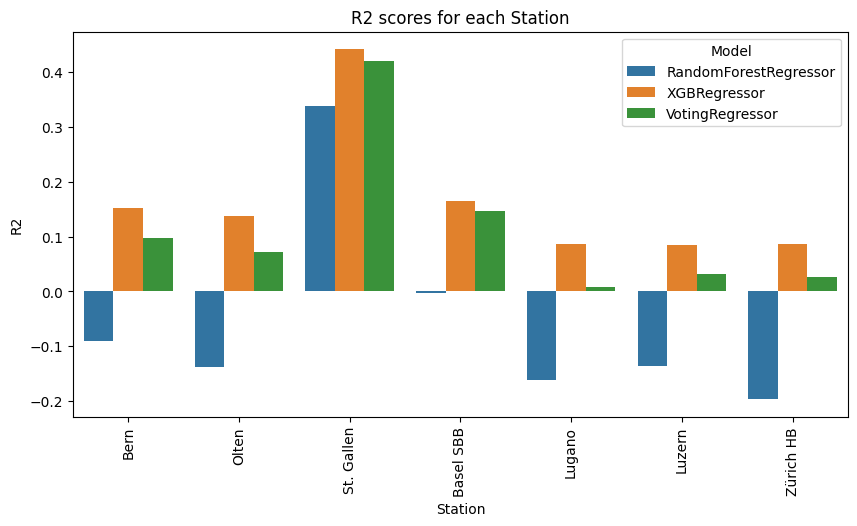

In [ ]:
# Plot results
plt.figure(figsize=(10, 5))
sns.barplot(data=all_results, x='station', y='R2', hue='modelname')
plt.title('R2 scores for each Station')
plt.ylabel('R2')
plt.xlabel('Station')
plt.xticks(rotation=90)
plt.legend(title='Model')
plt.show()

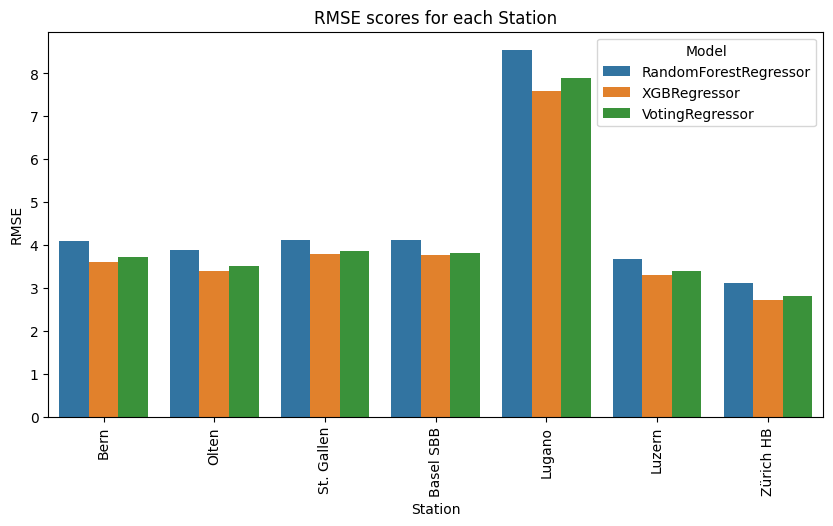

In [ ]:
# Concatenate dataframes and add station column
all_results = pd.concat([df.assign(station=station) for station, df in results_per_station.items()])

# Plot results
plt.figure(figsize=(10, 5))
sns.barplot(data=all_results, x='station', y='RMSE', hue='modelname')
plt.title('RMSE scores for each Station')
plt.ylabel('RMSE')
plt.xlabel('Station')
plt.xticks(rotation=90)
plt.legend(title='Model')
plt.show()

betriebstag

In [ ]:
data_full = pd.concat([data, betriebstage], axis=1)
data_full['BETRIEBSTAG'] = pd.to_datetime(data_full['BETRIEBSTAG'])
data_full['BETRIEBSTAG'] = data_full['BETRIEBSTAG'].dt.day_of_year.astype(int)
data_full.head(2)

,AN_diff,weekday,ab_hour,ab_minute,feiertag,week,haltestelle_an_Basel SBB,haltestelle_an_Bern,haltestelle_an_Lugano,haltestelle_an_Luzern,...,LINIEN_TEXT_IR37,LINIEN_TEXT_IR70,LINIEN_TEXT_IR75,Einschr_type_Aufgehoben:,Einschr_type_Einschraenkung,Einschr_type_Endmeldung:,Einschr_type_Keine,Einschr_type_Unterbruch,haltestelle_ab,BETRIEBSTAG
0,118.65,5,1,6,0,12,0,0,0,0,...,0,0,0,0,0,0,1,0,Bern,84
1,118.65,5,1,47,0,12,0,0,0,0,...,0,0,0,0,0,0,1,0,Olten,84


In [ ]:
# Initialize dictionary for storing models for each departure station
models_per_station_full = {}

# Initialize dictionary for storing results per station
results_per_station_full = {}

for station in haltestellen:
    # Filter the data for the current departure station
    data_station = data_full[data_full['haltestelle_ab'] == station]

    # Drop the departure station column
    data_station = data_station.drop('haltestelle_ab', axis=1)

    # Define X and y
    X = data_station.drop('AN_diff', axis=1)
    y = data_station['AN_diff']

    # Split data into train and test set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=4153)

    models = [
        # ('LinearRegression', LinearRegression()),
        ('RandomForestRegressor', RandomForestRegressor(random_state=4153)),
        ('XGBRegressor', XGBRegressor(random_state=4153))
    ]

    # Initialize list for base estimators of VotingRegressor
    estimators = {}

    # Initialize empty dataframe for results
    all_results_voting = pd.DataFrame()

    for name, model in models:
        model.fit(X_train, y_train)

        # Add the model to the estimators list
        estimators[name] = model

        # Predict y
        y_pred = model.predict(X_test)

        # Calculate metrics
        r2 = r2_score(y_test, y_pred)
        rmse = mean_squared_error(y_test, y_pred, squared=False)
        mape = mean_absolute_percentage_error(y_test, y_pred)

        # Save results in a dictionary
        result = {'R2': r2, 'RMSE': rmse, 'MAPE': mape, 'modelname': name}

        # Add to results dataframe
        all_results_voting = pd.concat([all_results_voting, pd.DataFrame([result])], ignore_index=True)

    # # find best model 
    # best_model_name = 'XGBRegressor' # all_results_voting.sort_values(by=['RMSE']).iloc[0]['modelname']
    # best_model = estimators[best_model_name]
    # # save best model
    # with open(f'App/Modell/Orte/{station}_{best_model_name}.pkl', 'wb') as f:
    #     pickle.dump(best_model, f)

    # Voting Regressor
    voting_regressor = VotingRegressor(list(estimators.items()))
    voting_regressor.fit(X_train, y_train)

    # Add model to estimators list
    estimators['VotingRegressor'] = voting_regressor

    # Predict y
    y_pred = voting_regressor.predict(X_test)

    # Calculate metrics
    r2 = r2_score(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    mape = mean_absolute_percentage_error(y_test, y_pred)

    # Save results in a dictionary
    result = {'R2': r2, 'RMSE': rmse, 'MAPE': mape, 'modelname': 'VotingRegressor'}

    # Add to results dataframe
    all_results_voting = pd.concat([all_results_voting, pd.DataFrame([result])], ignore_index=True)

    # Save the models and results for this departure station
    models_per_station_full[station] = estimators
    results_per_station_full[station] = all_results_voting

    print(f'Finished {station}')

plot

In [ ]:
# append _full to entries in columns station
all_results_full = pd.concat([df.assign(station=station) for station, df in results_per_station_full.items()])

all_results_full['modelname'] = all_results_full['modelname'].apply(lambda x: x + '_full')

# Concatenate dataframes and add station column
results = pd.concat([all_results, all_results_full], axis=0).sort_values(by=['station', 'modelname'])

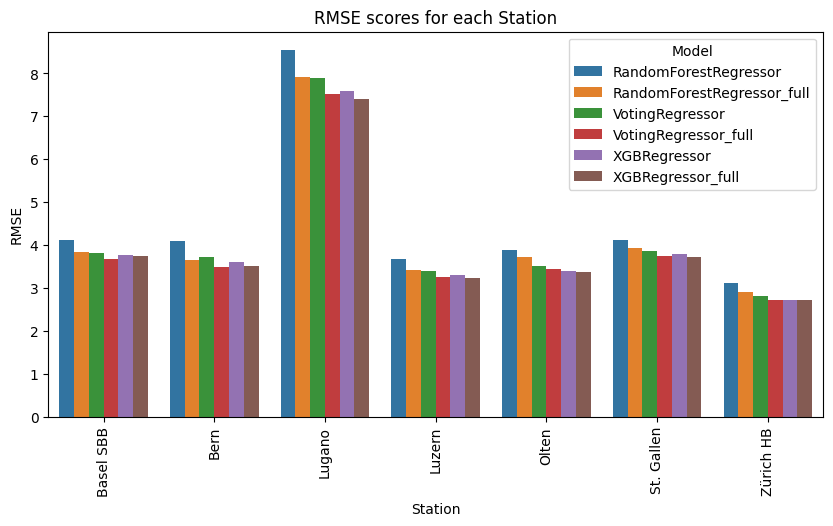

In [ ]:
# Plot results
plt.figure(figsize=(10, 5))
sns.barplot(data=results, x='station', y='RMSE', hue='modelname')
plt.title('RMSE scores for each Station')
plt.ylabel('RMSE')
plt.xlabel('Station')
plt.xticks(rotation=90)
plt.legend(title='Model')
plt.show()

In [ ]:
results

,R2,RMSE,MAPE,modelname,station
0,-0.002651,4.123669,2.485378e+13,RandomForestRegressor,Basel SBB
0,0.131157,3.838659,2.331329e+13,RandomForestRegressor_full,Basel SBB
2,0.146153,3.805389,2.351887e+13,VotingRegressor,Basel SBB
2,0.205597,3.670536,2.270811e+13,VotingRegressor_full,Basel SBB
1,0.164852,3.763488,2.413468e+13,XGBRegressor,Basel SBB
1,0.175722,3.738916,2.370606e+13,XGBRegressor_full,Basel SBB
0,-0.091027,4.098127,2.852570e+13,RandomForestRegressor,Bern
0,0.131084,3.657266,2.683127e+13,RandomForestRegressor_full,Bern
2,0.096814,3.728689,2.716722e+13,VotingRegressor,Bern
2,0.212466,3.481788,2.645570e+13,VotingRegressor_full,Bern
